# 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지마세요!


# 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

## 평가문항	상세기준
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? : CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? : Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? : 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

In [119]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

In [120]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 사용할 데이터셋 불러오기
    - stanford_dogs 데이터셋 사용
    - stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함
    - 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋

In [125]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,# TensorFlow and tf.keras
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


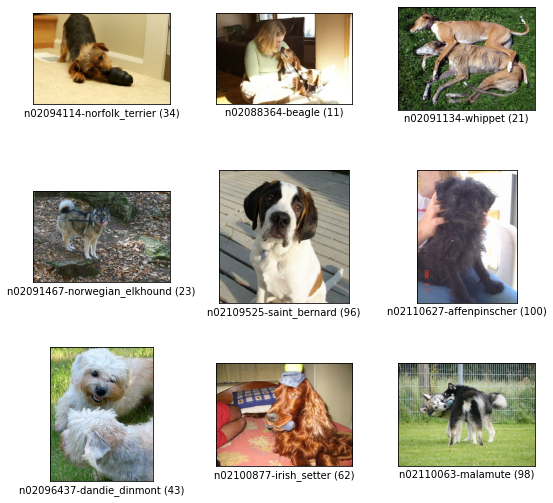

In [124]:
fig = tfds.show_examples(ds_info, ds_train)

# Augmentation 적용하기
## 텐서플로우 Random Augmentation API 사용하기

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

## 1) 이미지 섞기

- 가장 먼저 배치 내의 이미지를 두 개 골라서 섞어줌. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 함
- 예시를 위해 훈련데이터셋에서 이미지 2개를 가져옴
- 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수: 이미지를 텐서로 만들어 텐서플로우 연산을 사용
- 이때 이미지는 tfds에서 한 장을 뽑아서 사용

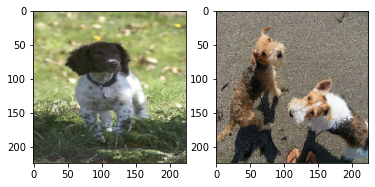

In [126]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

- 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, 
- a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 구현하기

In [127]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [128]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(100, shape=(), dtype=int32) tf.Tensor(143, shape=(), dtype=int32) tf.Tensor(212, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


- 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현하기

In [129]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

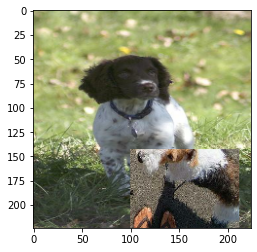

In [130]:
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

## 2) 라벨 섞기
- 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 함
- CutMix에서는 면적에 비례해서 라벨을 섞어주고, 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줌
    - 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 
    - image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줌
- 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 
    - A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용함
- 위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 보기

In [131]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [132]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18080357, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.81919646, 0.        , 0.        , 0.        ,
       0.     

## 심화 기법 (3) Cutmix() 함수 구현
1. ***이미지 섞는 부분*** : 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는 방법
    - Cutout은 이미지를 잘라내는 방식이고, Mixup은 특정 비율로 픽셀별 값을 섞는 방식
    - CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법  
2. ***라벨을 섞는 부분*** : 사진데이터를 잘라서 섞은 후에 전체사진에 차지하는 비율만큼 라벨을 새로 만들어 줌

- 위에서 구현한 두 함수 mix_2_label()과 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 보기

In [133]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

## 심화 기법 (4) Mixup Augmentation

- Mixup은 CutMix보다 간단하게 이미지와 라벨을 섞어줌
    - 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단함
- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됨

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.18080357 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.81919646 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

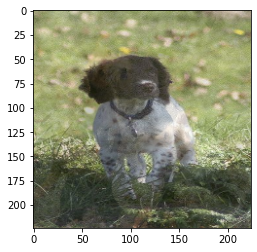

In [134]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

- 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 보기

In [135]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 1. Augmentation을 적용한 데이터셋 만들기
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 
그 이유는 CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

In [136]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [137]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.5)
    return image,label

In [138]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

In [139]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [140]:
def apply_normalize_on_dataset2(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [141]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [142]:
batch_size = 16

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [143]:
ds_train_normal = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size
)

In [144]:
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True
)

In [145]:
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True
)

In [146]:
ds_train_mixup = apply_normalize_on_dataset2(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_mixup=True
)

In [147]:
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# 2. 모델 만들기
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [148]:
num_classes = ds_info.features["label"].num_classes

In [149]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [150]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [151]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])                                               

In [152]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 3. 모델 훈련하기
모델을 훈련시켜 주세요.

위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해주세요!

그 이유는 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문입니다. 

In [153]:
tf.random.set_seed(2020)

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [154]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 119s 159ms/step - loss: 2.2255 - accuracy: 0.4381 - val_loss: 3.3695 - val_accuracy: 0.2042
Epoch 2/20
750/750 [==============================] - 113s 151ms/step - loss: 0.7703 - accuracy: 0.7817 - val_loss: 1.1152 - val_accuracy: 0.6720
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 0.3031 - accuracy: 0.9279 - val_loss: 1.0160 - val_accuracy: 0.7105
Epoch 4/20
750/750 [==============================] - 108s 144ms/step - loss: 0.1107 - accuracy: 0.9822 - val_loss: 0.9517 - val_accuracy: 0.7297
Epoch 5/20
750/750 [==============================] - 111s 147ms/step - loss: 0.0445 - accuracy: 0.9962 - val_loss: 0.9339 - val_accuracy: 0.7346
Epoch 6/20
750/750 [==============================] - 111s 147ms/step - loss: 0.0231 - accuracy: 0.9986 - val_loss: 0.9230 - val_accuracy: 0.7376
Epoch 7/20
750/750 [==============================] - 111s 147ms/step - loss: 0.0152 - accuracy: 0.9993 - val_loss: 0.9504 -

In [155]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 115s 154ms/step - loss: 2.5803 - accuracy: 0.3619 - val_loss: 1.9542 - val_accuracy: 0.4613
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 1.2993 - accuracy: 0.6282 - val_loss: 1.6158 - val_accuracy: 0.5466
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 0.8540 - accuracy: 0.7492 - val_loss: 1.4247 - val_accuracy: 0.6002
Epoch 4/20
750/750 [==============================] - 117s 156ms/step - loss: 0.5736 - accuracy: 0.8321 - val_loss: 1.4906 - val_accuracy: 0.5972
Epoch 5/20
750/750 [==============================] - 118s 157ms/step - loss: 0.3886 - accuracy: 0.8915 - val_loss: 1.5006 - val_accuracy: 0.5946
Epoch 6/20
750/750 [==============================] - 115s 154ms/step - loss: 0.2486 - accuracy: 0.9387 - val_loss: 1.2878 - val_accuracy: 0.6483
Epoch 7/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1633 - accuracy: 0.9642 - val_loss: 1.3661 -

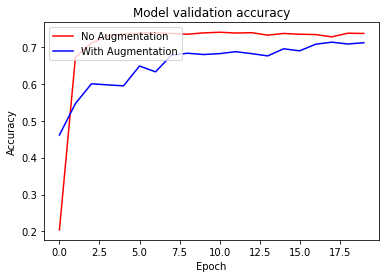

In [156]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

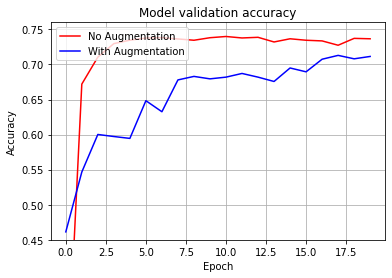

In [164]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.45, 0.76)
plt.show()

In [158]:
history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 117s 155ms/step - loss: 2.2102 - accuracy: 0.4437 - val_loss: 3.1774 - val_accuracy: 0.2451
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 0.7930 - accuracy: 0.7750 - val_loss: 1.0924 - val_accuracy: 0.6819
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 0.2989 - accuracy: 0.9279 - val_loss: 0.9812 - val_accuracy: 0.7135
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 0.0969 - accuracy: 0.9862 - val_loss: 0.9618 - val_accuracy: 0.7257
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 0.0375 - accuracy: 0.9973 - val_loss: 0.9167 - val_accuracy: 0.7448
Epoch 6/20
750/750 [==============================] - 122s 163ms/step - loss: 0.0382 - accuracy: 0.9967 - val_loss: 0.9694 - val_accuracy: 0.7310
Epoch 7/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0255 - accuracy: 0.9976 - val_loss: 0.9305 -

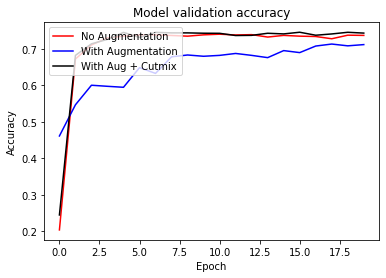

In [159]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix'], loc='upper left')
plt.show()

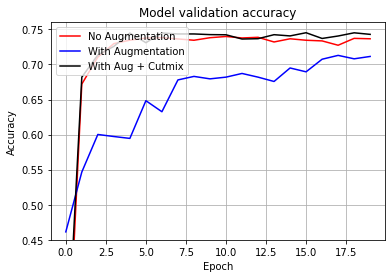

In [165]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.45, 0.76)
plt.show()

In [161]:
history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:23 - loss: 4.8537 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0549s vs `on_train_batch_end` time: 0.0834s). Check your callbacks.


750/750 [==============================] - 110s 147ms/step - loss: 2.5719 - accuracy: 0.3594 - val_loss: 1.7990 - val_accuracy: 0.4977
Epoch 2/20
750/750 [==============================] - 110s 146ms/step - loss: 1.2802 - accuracy: 0.6324 - val_loss: 2.3209 - val_accuracy: 0.4040
Epoch 3/20
750/750 [==============================] - 110s 146ms/step - loss: 0.8366 - accuracy: 0.7560 - val_loss: 2.3431 - val_accuracy: 0.4131
Epoch 4/20
750/750 [==============================] - 110s 146ms/step - loss: 0.5874 - accuracy: 0.8275 - val_loss: 1.5993 - val_accuracy: 0.5726
Epoch 5/20
750/750 [==============================] - 110s 146ms/step - loss: 0.3794 - accuracy: 0.8968 - val_loss: 1.3329 - val_accuracy: 0.6356
Epoch 6/20
750/750 [==============================] - 110s 146ms/step - loss: 0.2476 - accuracy: 0.9360 - val_loss: 1.3753 - val_accuracy: 0.6281
Epoch 7/20
750/750 [==============================] - 110s 146ms/step - loss: 0.1692 - accuracy: 0.9605 - val_loss: 1.2197 - val_accura

# 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

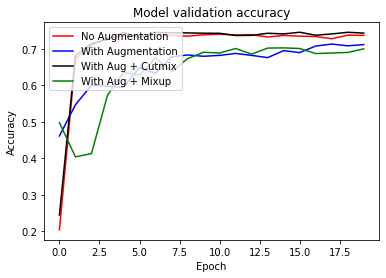

In [162]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix', 'With Aug + Mixup'], loc='upper left')
plt.show()

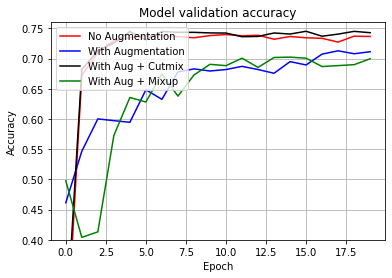

In [166]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix', 'With Aug + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.4, 0.76)
plt.show()

# 5. Augmentation에 의한 모델 성능 비교

- 아래 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기 성능 비교
    - No Augmentation: loss: 0.0041 - accuracy: 0.9997 - val_loss: 1.0271 - val_accuracy: 0.7366
    - 기본 Augmentation: loss: 0.0070 - accuracy: 0.9995 - val_loss: 1.1890 - val_accuracy: 0.7114
    - ***기본 + CutMix 적용***: loss: 0.0033 - ***accuracy: 0.9999*** - val_loss: 1.0145 - val_accuracy: ***0.7429***   ***->성능이 가장 좋았습니다!***
    - 기본 + Mixup 적용: loss: 0.0160 - accuracy: 0.9974 - val_loss: 1.2503 - val_accuracy: 0.6997 
- 아래와 같이 ***다양한 방식으로 Augmentation 방법***을 적용해 보았습니다. 
    - image = tf.image.random_flip_left_right(image)
    - image = tf.image.random_brightness(image, max_delta=0.2)
    - image = tf.image.random_crop(image, [224, 224, 3])
    - image = tf.image.random_hue(image, max_delta=0.2)
    - image = tf.image.random_contrast(image, lower=0.1, upper=0.5) 

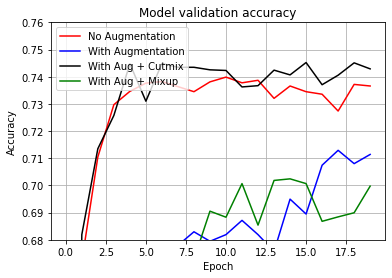

In [171]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix', 'With Aug + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.68, 0.76)
plt.show()